In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Add project root to Python path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import *
from src.features import *
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline

In [2]:
train_df = load_train_data()
train = train_df.copy()
test_df = load_test_data()
test = test_df.copy()
train = train.drop(columns='id')
test = test.drop(columns='id')

In [3]:
pd.set_option('display.max_columns', None)
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
def resumetable2(df, target_col, missing_value=-1, ignore_cols=None, verbose=True):
    ignore_cols = ignore_cols or []
    if verbose:
        print(f'Data shape: {df.shape}')

    summary = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summary['Missing'] = (df == missing_value).sum().values
    summary['Nunique'] = df.nunique().values
    summary['Feature Type'] = None

    for col in df.columns:
        if 'target' in col:
            summary.loc[col, 'Feature Type'] = 'Target'
        elif 'bin' in col:
            summary.loc[col, 'Feature Type'] = 'Binary'
        elif 'cat' in col:
            summary.loc[col, 'Feature Type'] = 'Categorical'
        else:
            summary.loc[col, 'Feature Type'] = 'Temp'
            
    summary = summary.sort_values(by='Feature Type')
    return summary

In [5]:
feature_table = resumetable2(train, 'target')

Data shape: (595212, 58)


In [6]:
cat_cols = feature_table[feature_table['Feature Type'] == 'Categorical'].index.tolist()
cat_cols = cat_cols + feature_table[feature_table['Feature Type'] == 'Binary'].index.tolist()
cat_cols = cat_cols + feature_table[(feature_table['Nunique'] < 30) & (feature_table['Feature Type'] == 'Temp')].index.tolist()
num_cols = feature_table[(feature_table['Nunique'] >= 30) & (feature_table['Feature Type'] == 'Temp')].index.tolist()

In [7]:
train['target'].value_counts()

target
0    573518
1     21694
Name: count, dtype: int64

1. value_counts: stratified kfold 사용 필요, 타겟값 불균형
2. target 데이터부터 시각화 시작

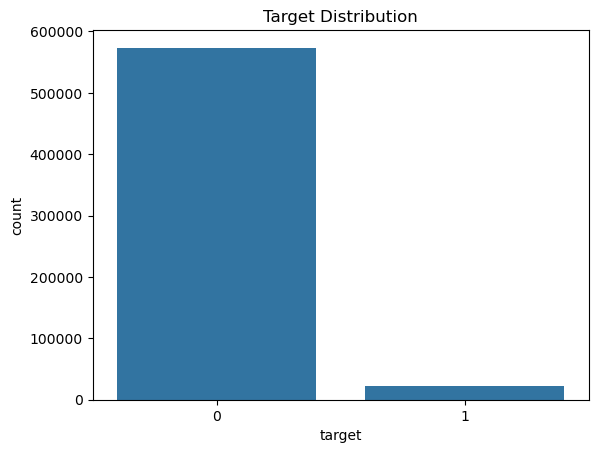

In [8]:
sns.countplot(data=train, x='target')
plt.title('Target Distribution')
plt.show()

In [9]:
from sklearn.metrics import roc_auc_score

def gini_normalized(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

In [10]:
# Pipeline -> Baseline model

# 타겟 정의  
X = train.drop(columns='target')
y = train['target']

# 전처리기 & 피처 생성기 정의 
interaction_fe = InteractionFeatureGenerator()

# 모델 정의 
model = LGBMClassifier(random_state=42)

# 파이프라인 생성 
pipeline = make_pipeline(
    interaction_fe,
    model
)

# 교차 검증 및 평가 
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    pipeline.fit(X_train, y_train)
    
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    score = gini_normalized(y_val.values, y_pred_proba)
    cv_scores.append(score)
    
    print(f'Fold {fold+1} Gini Normalized: {score: .5f}')
    
# 결과
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f'Baseline CV Score: {mean_cv_score: .5f} +/- {std_cv_score: .5f}')

[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Fold 1 Gini Normalized:  0.28310
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 476169, number of

### model.predict_proba()
이진분류에서 predict_proba()는 2차원 배열을 반환 <br>
y_pred_proba = model.predict_proba(X_val)<br>
print(y_pred_proba.shape)  # (n_samples, 2)<br>
print(y_pred_proba[:3])    # 처음 3개 샘플 예시<br>

출력 예시:

[[0.8, 0.2],   첫 번째 샘플: 80% 확률로 class 0, 20% 확률로 class 1 <br>
 [0.3, 0.7],   두 번째 샘플: 30% 확률로 class 0, 70% 확률로 class 1 <br>
 [0.9, 0.1]]   세 번째 샘플: 90% 확률로 class 0, 10% 확률로 class 1 <br>
 

[:, 1]의 의미:<br>
첫 번째 차원(행): 모든 샘플 선택 (:)<br>
두 번째 차원(열): index 1 선택 (1) = class 1의 확률<br>
y_pred_proba[:, 1]  # class 1 확률 (사고 날 확률) <- 우리가 원하는 값

In [11]:
# param_sets = [
#     # Baseline (현재)
#     {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': -1},
    
#     # Set 1: 더 많은 트리, 낮은 학습률
#     {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 64},
    
#     # Set 2: 더 깊은 트리
#     {'n_estimators': 1500, 'learning_rate': 0.03, 'max_depth': 8, 'num_leaves': 100},
    
#     # Set 3: 정규화 강화
#     {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 50, 
#      'min_child_samples': 100, 'subsample': 0.8, 'colsample_bytree': 0.8}
# ]

# best_score = 0
# best_params = None

# for i, params in enumerate(param_sets):
#     print(f"\n=== Testing Parameter Set {i+1} ===")
#     print(f"Params: {params}")
    
#     # 모델 생성
#     model = LGBMClassifier(random_state=42, **params)
    
#     # 파이프라인 생성
#     pipeline = make_pipeline(interaction_fe, model)
    
#     # CV 실행
#     cv_scores = []
#     for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#         X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#         X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
#         pipeline.fit(X_train, y_train)
#         y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
#         score = gini_normalized(y_val.values, y_pred_proba)
#         cv_scores.append(score)
    
#     # 결과 출력
#     mean_score = np.mean(cv_scores)
#     std_score = np.std(cv_scores)
#     print(f"CV Score: {mean_score:.5f} +/- {std_score:.5f}")
    
#     # 최고 점수 업데이트
#     if mean_score > best_score:
#         best_score = mean_score
#         best_params = params
        
# print(f"\n=== BEST RESULT ===")
# print(f"Best Score: {best_score:.5f}")
# print(f"Best Params: {best_params}")


In [12]:
def gini_normalized(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

def quick_cv_test(train, feature_name, baseline_score=0.27440):
    train_test = train.copy()
    
    # 타겟 분리
    X = train_test.drop(columns='target')
    y = train_test['target']
    
    # 모델 및 CV 설정
    model = LGBMClassifier(random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # CV 실행
    cv_scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        score = gini_normalized(y_val.values, y_pred)
        cv_scores.append(score)
    
    mean_score = np.mean(cv_scores)
    
    # 결과 출력
    improvement = mean_score - baseline_score
    print(f'{feature_name}: {mean_score:.5f} ({improvement:+.5f})')
    
    return mean_score





### Feature Engineering 

In [13]:
corr_with_target = train.corr()['target'].abs().sort_values(ascending=False)
# .abs(): 절댓값 제시, 타겟 예측에는 절댓값이 중요 
print(corr_with_target.head(15))

target           1.000000
ps_car_13        0.053899
ps_car_12        0.038790
ps_ind_17_bin    0.037053
ps_car_07_cat    0.036395
ps_reg_02        0.034800
ps_ind_07_bin    0.034218
ps_ind_06_bin    0.034017
ps_car_04_cat    0.032900
ps_car_03_cat    0.032401
ps_car_02_cat    0.031534
ps_reg_03        0.030888
ps_ind_05_cat    0.029165
ps_ind_16_bin    0.027778
ps_car_15        0.027667
Name: target, dtype: float64


In [14]:
# 원본으로 초기화
train = train_df.drop(columns=['id']).copy()

## Feature Engineering으로 무한 머리박기 
train['reg03/reg02'] = train['ps_reg_03'] / (train['ps_reg_02'] + 1e-8)


# 타겟 정의  
X = train.drop(columns='target')
y = train['target']

# 전처리기 & 피처 생성기 정의 
# interaction_fe = InteractionFeatureGenerator()

# 모델 정의 / 머리 박아보면서 feature engineering 검증 -> 파이프라인 없이 과정 최소화하며 바로 검증 
model = LGBMClassifier(random_state=42)

# 교차 검증 및 평가 
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = gini_normalized(y_val.values, y_pred_proba)
    cv_scores.append(score)
    
    print(f'Fold {fold+1} Gini Normalized: {score: .5f}')
    
# 결과
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f'Feature Engineered CV Score: {mean_cv_score: .5f} +/- {std_cv_score: .5f}')

[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Fold 1 Gini Normalized:  0.28617
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 476169, number of

### 분석
1. ps_ind_xx_bin: 거의 대부분의 feature가 의미 적음 


In [15]:
model.fit(X_train, y_train)
gain_importance = model.booster_.feature_importance(importance_type='gain')

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gain_importance
}).sort_values('importance', ascending=False)

[LightGBM] [Info] Number of positive: 17355, number of negative: 458815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 476170, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274766
[LightGBM] [Info] Start training from score -3.274766


In [16]:
top_features = feature_importance_df.head(100)
low_features = feature_importance_df.tail(3)
low_features

,feature,importance
12,ps_ind_13_bin,0.0
9,ps_ind_10_bin,0.0
10,ps_ind_11_bin,0.0


In [17]:
top_features_names = feature_importance_df.head(15)['feature'].tolist()
correlation_matrix = train[top_features_names].corr()
correlation_matrix

,ps_car_13,ps_ind_03,ps_reg_03,ps_ind_05_cat,ps_ind_15,ps_ind_17_bin,reg03/reg02,ps_car_14,ps_reg_02,ps_ind_01,ps_car_01_cat,ps_car_07_cat,ps_reg_01,ps_car_03_cat,ps_calc_10
ps_car_13,1.000000,0.048308,0.099415,-0.015259,-0.037885,0.055626,0.008900,-0.037310,0.194316,0.099752,0.167127,-0.223412,0.027097,0.184690,0.001044
ps_ind_03,0.048308,1.000000,0.002348,0.053250,0.170449,0.027691,-0.011499,0.000539,0.048338,0.223408,-0.028520,0.056337,0.003209,0.095658,0.000230
ps_reg_03,0.099415,0.002348,1.000000,-0.019510,0.001956,0.059237,0.271879,0.006271,0.516457,0.139125,0.230339,-0.053356,0.637035,0.054902,-0.000138
ps_ind_05_cat,-0.015259,0.053250,-0.019510,1.000000,0.012326,0.007163,0.000990,-0.001427,-0.009124,0.014823,-0.036213,0.053777,-0.017836,-0.011399,-0.001070
ps_ind_15,-0.037885,0.170449,0.001956,0.012326,1.000000,-0.021884,0.030108,-0.005253,0.021702,0.122137,0.025690,0.059703,-0.051826,0.065398,-0.001279
ps_ind_17_bin,0.055626,0.027691,0.059237,0.007163,-0.021884,1.000000,-0.004817,-0.012650,0.033383,0.101257,0.058876,-0.043662,0.069967,0.137328,-0.000699
reg03/reg02,0.008900,-0.011499,0.271879,0.000990,0.030108,-0.004817,1.000000,-0.003384,-0.242790,-0.003305,0.003789,0.005216,-0.161803,-0.003786,0.003034
ps_car_14,-0.037310,0.000539,0.006271,-0.001427,-0.005253,-0.012650,-0.003384,1.000000,0.004147,0.034480,-0.027170,0.020895,0.012704,-0.163385,-0.002534
ps_reg_02,0.194316,0.048338,0.516457,-0.009124,0.021702,0.033383,-0.242790,0.004147,1.000000,0.183855,0.231710,-0.069651,0.471027,0.104317,0.000190
ps_ind_01,0.099752,0.223408,0.139125,0.014823,0.122137,0.101257,-0.003305,0.034480,0.183855,1.000000,-0.056121,-0.000639,0.102212,0.043756,-0.001345


In [18]:
# 타겟 변수와의 관계
corr_with_target = train.corr()['target'].abs().sort_values(ascending=False)
# .abs(): 절댓값 제시, 타겟 예측에는 절댓값이 중요 
print(corr_with_target.head(15))

target           1.000000
ps_car_13        0.053899
ps_car_12        0.038790
ps_ind_17_bin    0.037053
ps_car_07_cat    0.036395
ps_reg_02        0.034800
ps_ind_07_bin    0.034218
ps_ind_06_bin    0.034017
ps_car_04_cat    0.032900
ps_car_03_cat    0.032401
ps_car_02_cat    0.031534
ps_reg_03        0.030888
ps_ind_05_cat    0.029165
ps_ind_16_bin    0.027778
ps_car_15        0.027667
Name: target, dtype: float64


## Insights
1. reg_03/02/01은 서로 상관관계가 높음 그러나 reg_03은 importance가 굉장히 높은데 01/02는 그렇지 않음 하지만 target과의 corr값에서 02가 제일 높고 오히려 03이 그보다 낮으며, 01은 상위에 포함되지도 않음
2. 



In [19]:
def test_feature_combination(new_name, feat1, feat2, operation='*'):
    train_copy = train_df.drop(columns=['id']).copy()
    
    if operation == '*':
        train_copy[new_name] = train_copy[feat1] * train_copy[feat2]
    elif operation == '/':
        train_copy[new_name] = train_copy[feat1] / (train_copy[feat2] + 1e-8)
    elif operation == '-':
        train_copy[new_name] = train_copy[feat1] - train_copy[feat2]

    
    score = quick_cv_test(train_copy, new_name)
    
    if score > 0.27440:
        print(f'Keep {new_name}')
        return True
    else:
        print(f'Drop {new_name}')
        train_copy = train_copy.drop(columns=[new_name])
        return False

test_feature_combination('reg03 * reg02', 'ps_reg_03', 'ps_reg_02', operation='*')
print('-----------------------------')
test_feature_combination('reg03 / reg02', 'ps_reg_03', 'ps_reg_02', operation='/')
print('-----------------------------')
test_feature_combination('reg03 - reg02', 'ps_reg_03', 'ps_reg_02', operation='-')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `forc

True

In [20]:
train_cols = train.columns.tolist()

calc_cols = []
calc_bin_cols = []
for col in train_cols:
    if 'calc' in col:
        if 'bin' in col:
            calc_bin_cols.append(col)
        else: 
            calc_cols.append(col)
            
ind_cols = []
ind_bin_cols = []
ind_cat_cols = []

for col in train_cols:
    if 'ind' in col:
        if 'bin' in col:
            ind_bin_cols.append(col)
        if 'cat' in col:
            ind_cat_cols.append(col)
        else:
            ind_cols.append(col)
            
reg_cols = []
for col in train_cols:
    if 'reg' in col:
        reg_cols.append(col)
            
car_cols = []
car_cat_cols = []
for col in train_cols:
    if 'car' in col:
        if 'cat' in col:
            car_cat_cols.append(col)
        else: 
            car_cols.append(col)

In [21]:
all_calc_cols = calc_cols + calc_bin_cols
all_ind_cols = ind_cols + ind_bin_cols + ind_cat_cols
all_reg_cols = reg_cols
all_car_cols = car_cols + car_cat_cols

top_calc = ['ps_calc_10']
rest_calc = [col for col in all_calc_cols if col not in top_calc]

In [22]:
train_test = train_df.drop(columns='id').copy()
train_test['reg03/reg02'] = train_test['ps_reg_03'] / (train_test['ps_reg_02'] + 1e-8)

In [23]:
train_test = train_test.drop(columns=rest_calc)

In [24]:
quick_cv_test(train_test, 'rest_calc_remove', baseline_score=0.27576)

[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1460
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 39
[LightGBM] [In

np.float64(0.2782416401227291)

In [25]:
train_test = train_df.drop(columns='id').copy()
train_test['reg03/reg02'] = train_test['ps_reg_03'] / (train_test['ps_reg_02'] + 1e-8)
train_test = train_test.drop(columns=rest_calc)
train_test_check = train_test.copy()

In [26]:
quick_cv_test(train_test, 'low_features_remove', baseline_score=0.27824)

[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1460
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 39
[LightGBM] [In

np.float64(0.2782416401227291)

In [27]:
low_features['feature'].tolist()

['ps_ind_13_bin', 'ps_ind_10_bin', 'ps_ind_11_bin']

In [101]:
train_test = train_df.drop(columns='id').copy()
train_test['reg03/reg02'] = train_test['ps_reg_03'] / (train_test['ps_reg_02'] + 1e-8)
train_test['car02cat/car07cat'] = train_test['ps_car_02_cat'] / (train_test['ps_car_07_cat'] + 1e-8)
train_test = train_test.drop(columns=rest_calc)

# feature 추가 


In [102]:
quick_cv_test(train_test, 'test', baseline_score=0.27882)

[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1461
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 40
[LightGBM] [In

np.float64(0.27882420684276443)

In [30]:
correlation_matrix

,ps_car_13,ps_ind_03,ps_reg_03,ps_ind_05_cat,ps_ind_15,ps_ind_17_bin,reg03/reg02,ps_car_14,ps_reg_02,ps_ind_01,ps_car_01_cat,ps_car_07_cat,ps_reg_01,ps_car_03_cat,ps_calc_10
ps_car_13,1.000000,0.048308,0.099415,-0.015259,-0.037885,0.055626,0.008900,-0.037310,0.194316,0.099752,0.167127,-0.223412,0.027097,0.184690,0.001044
ps_ind_03,0.048308,1.000000,0.002348,0.053250,0.170449,0.027691,-0.011499,0.000539,0.048338,0.223408,-0.028520,0.056337,0.003209,0.095658,0.000230
ps_reg_03,0.099415,0.002348,1.000000,-0.019510,0.001956,0.059237,0.271879,0.006271,0.516457,0.139125,0.230339,-0.053356,0.637035,0.054902,-0.000138
ps_ind_05_cat,-0.015259,0.053250,-0.019510,1.000000,0.012326,0.007163,0.000990,-0.001427,-0.009124,0.014823,-0.036213,0.053777,-0.017836,-0.011399,-0.001070
ps_ind_15,-0.037885,0.170449,0.001956,0.012326,1.000000,-0.021884,0.030108,-0.005253,0.021702,0.122137,0.025690,0.059703,-0.051826,0.065398,-0.001279
ps_ind_17_bin,0.055626,0.027691,0.059237,0.007163,-0.021884,1.000000,-0.004817,-0.012650,0.033383,0.101257,0.058876,-0.043662,0.069967,0.137328,-0.000699
reg03/reg02,0.008900,-0.011499,0.271879,0.000990,0.030108,-0.004817,1.000000,-0.003384,-0.242790,-0.003305,0.003789,0.005216,-0.161803,-0.003786,0.003034
ps_car_14,-0.037310,0.000539,0.006271,-0.001427,-0.005253,-0.012650,-0.003384,1.000000,0.004147,0.034480,-0.027170,0.020895,0.012704,-0.163385,-0.002534
ps_reg_02,0.194316,0.048338,0.516457,-0.009124,0.021702,0.033383,-0.242790,0.004147,1.000000,0.183855,0.231710,-0.069651,0.471027,0.104317,0.000190
ps_ind_01,0.099752,0.223408,0.139125,0.014823,0.122137,0.101257,-0.003305,0.034480,0.183855,1.000000,-0.056121,-0.000639,0.102212,0.043756,-0.001345


In [31]:
top_features.head(15)

,feature,importance
34,ps_car_13,7949.388527
2,ps_ind_03,3398.219804
20,ps_reg_03,3372.933639
4,ps_ind_05_cat,3223.870274
14,ps_ind_15,2678.467430
16,ps_ind_17_bin,2282.083090
57,reg03/reg02,2197.275825
35,ps_car_14,1738.022992
19,ps_reg_02,1565.612011
0,ps_ind_01,1548.323184


In [104]:
good_features

['ps_car_13: 0.278824320968703',
 'ps_car_12: 0.27882420684276443',
 'ps_ind_17_bin: 0.27882420684276443',
 'ps_reg_02: 0.27882420684276443',
 'ps_ind_07_bin: 0.27882420684276443',
 'ps_ind_06_bin: 0.27882420684276443',
 'ps_car_04_cat: 0.27882420684276443',
 'ps_ind_16_bin: 0.27882420684276443',
 'ps_car_15: 0.27882420684276443']

In [32]:
corr_with_target.head(15)

target           1.000000
ps_car_13        0.053899
ps_car_12        0.038790
ps_ind_17_bin    0.037053
ps_car_07_cat    0.036395
ps_reg_02        0.034800
ps_ind_07_bin    0.034218
ps_ind_06_bin    0.034017
ps_car_04_cat    0.032900
ps_car_03_cat    0.032401
ps_car_02_cat    0.031534
ps_reg_03        0.030888
ps_ind_05_cat    0.029165
ps_ind_16_bin    0.027778
ps_car_15        0.027667
Name: target, dtype: float64

In [93]:
good_features = []
top = corr_with_target.head(15).index.tolist()
top.remove('target')
for features in top:
    train_test = train_df.drop(columns='id').copy()
    train_test['reg03/reg02'] = train_test['ps_reg_03'] / (train_test['ps_reg_02'] + 1e-8)
    train_test['car02cat/car07cat'] = train_test['ps_car_02_cat'] / (train_test['ps_car_07_cat'] + 1e-8)
    train_test = train_test.drop(columns=rest_calc)

    # feature 추가 
    # train_test['test'] = train_test['ps_car_12'] / (train_test[f'{features}'] + 1e-8)
    train_test['test'] = train_test[f'{features}'] ** 2
    
    score = quick_cv_test(train_test, 'test', baseline_score=0.27882)
    if score > 0.27882:
        good_features.append(f'{features}: {score}')

[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1716
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 41
[LightGBM] [In

In [106]:
train_test = train_df.drop(columns='id').copy()
train_test['reg03/reg02'] = train_test['ps_reg_03'] / (train_test['ps_reg_02'] + 1e-8)
train_test = train_test.drop(columns=rest_calc)
train_test_check = train_test.copy()

In [109]:
group_mean = train_test.groupby('ps_ind_02_cat')['ps_car_13'].mean()
train['car13_mean_by_ind02'] = train['ps_ind_02_cat'].map(group_mean)

In [110]:
quick_cv_test(train_test, 'test', baseline_score=0.27882)

[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1460
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 39
[LightGBM] [In

np.float64(0.2782416401227291)

In [112]:
import optuna

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'None',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    train_data = train_df.drop(columns='id').copy()
    train_data['reg03/reg02'] = train_data['ps_reg_03'] / (train_data['ps_reg_02'] + 1e-8)
    train_data['car02cat/car07cat'] = train_data['ps_car_02_cat'] / (train_data['ps_car_07_cat'] + 1e-8)
    train_data = train_data.drop(columns=rest_calc)
    
    X = train_data.drop(columns='target')
    y = train_data['target']
    
    # 5-fold CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = LGBMClassifier(**params)
        model.fit(X_train, y_train)
        
        pred = model.predict_proba(X_val)[:, 1]
        score = gini_normalized(y_val, pred)
        scores.append(score)
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

/opt/anaconda3/envs/DriverPred/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-27 16:18:29,757] A new study created in memory with name: no-name-1d831149-7b48-4a93-991e-0a77fc9fd991
[I 2025-06-27 16:19:14,574] Trial 0 finished with value: 0.2788103880402309 and parameters: {'n_estimators': 1821, 'learning_rate': 0.024177891965198043, 'max_depth': 4, 'num_leaves': 83, 'min_child_samples': 109, 'subsample': 0.8869006494743602, 'colsample_bytree': 0.8496920451626392, 'reg_alpha': 0.2527559287819038, 'reg_lambda': 0.045953980818960835}. Best is trial 0 with value: 0.2788103880402309.
[I 2025-06-27 16:21:17,872] Trial 1 finished with value: 0.18144176196993872 and parameters: {'n_estimators': 1672, 'learning_rate': 0.07662129557451254, 'max_depth': 7, 'num_leaves': 100, 'min_child_samples': 81, 's

Best parameters: {'n_estimators': 1038, 'learning_rate': 0.013281377932256606, 'max_depth': 6, 'num_leaves': 28, 'min_child_samples': 50, 'subsample': 0.7290404930495044, 'colsample_bytree': 0.7101352369500463, 'reg_alpha': 0.18001601412071802, 'reg_lambda': 4.7290215803443365}
Best score: 0.2853958763193618


Trial 200/200 완료
현재 최고 점수: 0.28540
현재 최고 파라미터: {'n_estimators': 1038, 'learning_rate': 0.013281377932256606, 'max_depth': 6, 'num_leaves': 28, 'min_child_samples': 50, 'subsample': 0.7290404930495044, 'colsample_bytree': 0.7101352369500463, 'reg_alpha': 0.18001601412071802, 'reg_lambda': 4.7290215803443365}
